### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

data_folder = './data/'
lalonde = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
lalonde.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
607,PSID423,0,27,10,1,0,0,1,0.0000,0.0000,7543.794
87,NSW88,1,26,11,1,0,0,1,0.0000,0.0000,17230.960
223,PSID39,0,49,8,0,0,1,1,6459.7030,7431.6290,7503.896
97,NSW98,1,42,12,1,0,0,0,0.0000,0.0000,2456.153
462,PSID278,0,16,7,1,0,0,1,133.2301,205.8871,6145.865
393,PSID209,0,16,10,0,0,0,1,574.0652,1181.6130,5578.418
160,NSW161,1,22,9,1,0,0,1,2192.8770,3836.9860,3462.564
428,PSID244,0,36,8,0,0,1,1,2715.5440,585.4355,0.000
172,NSW173,1,20,9,0,1,0,1,12260.7800,5875.0490,1358.643
16,NSW17,1,27,13,1,0,0,0,0.0000,0.0000,14581.860


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

In [3]:
print((lalonde.treat == 1).sum())
print((lalonde.treat == 0).sum())

185
429


In [4]:
lalonde[lalonde.treat == 1].re78.describe()

count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64

In [5]:
lalonde[lalonde.treat == 0].re78.describe()

count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

In [6]:
def bootstrap_CI(data, n_samples=1000, confidence=0.95):
    means = np.zeros(n_samples)
    data = np.array(data)
    for i in range(n_samples):
        sample = np.random.choice(data, size=len(data), replace=True)
        means[i] = sample.mean()
    
    conf_interval = np.nanpercentile(means,[100*(1-confidence)/2, 100*(1-(1-confidence)/2)])
    return conf_interval


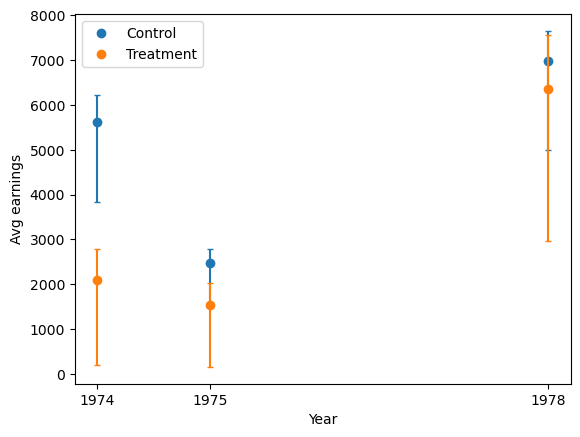

In [7]:
df_nw = lalonde.groupby(["treat"]).apply(lambda x: pd.Series({ 
        're74_mean': x['re74'].mean(),
        're74_bounds': bootstrap_CI(x['re74'].values),
        're75_mean': x['re75'].mean(),
        're75_bounds': bootstrap_CI(x['re75'].values),
        're78_mean': x['re78'].mean(),
        're78_bounds': bootstrap_CI(x['re78'].values),        
    }))


#plot errorbars from previously obtained filtered df
years = [1974,1975,1978]
p = plt.plot(years, df_nw.loc[0, ['re74_mean', 're75_mean', 're78_mean']], 'o', label='Control')
plt.errorbar(years, df_nw.loc[0,['re74_bounds', 're75_bounds', 're78_bounds']].apply(lambda x: x[0]), yerr=df_nw.loc[0,['re74_bounds', 're75_bounds', 're78_bounds']].apply(lambda x: x[1]-x[0]), fmt="none", ecolor=p[0].get_color(), capsize=2)

p = plt.plot(years, df_nw.loc[1, ['re74_mean', 're75_mean', 're78_mean']], 'o', label='Treatment')
plt.errorbar(years, df_nw.loc[1,['re74_bounds', 're75_bounds', 're78_bounds']].apply(lambda x: x[0]), yerr=df_nw.loc[1,['re74_bounds', 're75_bounds', 're78_bounds']].apply(lambda x: x[1]-x[0]), fmt="none", ecolor=p[0].get_color(), capsize=2)

plt.xticks(years)
plt.legend()
plt.ylabel('Avg earnings')
plt.xlabel('Year')
plt.show()


In [8]:
print('Difference in means with 95% confidence interval')
print('1974: ', df_nw.loc[1, 're74_mean'] - df_nw.loc[0, 're74_mean'], df_nw.loc[1, 're74_bounds'] - df_nw.loc[0, 're74_bounds'])
print('1975: ', df_nw.loc[1, 're75_mean'] - df_nw.loc[0, 're75_mean'], df_nw.loc[1, 're75_bounds'] - df_nw.loc[0, 're75_bounds'])
print('1978: ', df_nw.loc[1, 're78_mean'] - df_nw.loc[0, 're78_mean'], df_nw.loc[1, 're78_bounds'] - df_nw.loc[0, 're78_bounds'])

Difference in means with 95% confidence interval
1974:  -3523.6628177382986 [-3537.13693355 -3435.07687262]
1975:  -934.4291293397607 [-1075.05000935  -758.23926929]
1978:  -635.0262120374273 [-1059.22993172  -100.62559282]


In [9]:
treated = lalonde[lalonde['treat'] == 1] #People that attained the programme
control = lalonde[lalonde['treat'] == 0] #People that didn't attain the programme

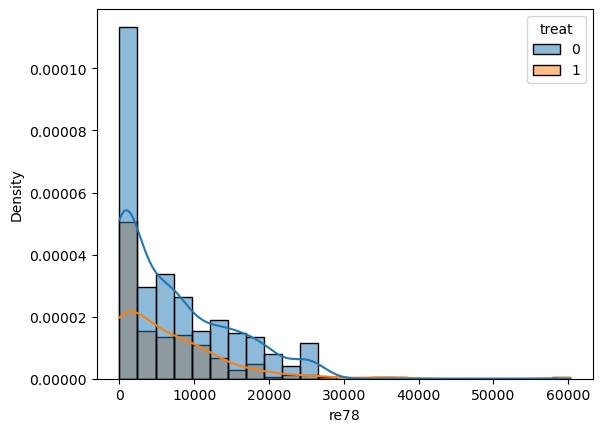

In [10]:
ax = sns.histplot(data=lalonde, x='re78', hue='treat', stat='density', kde=True, log_scale=(False))

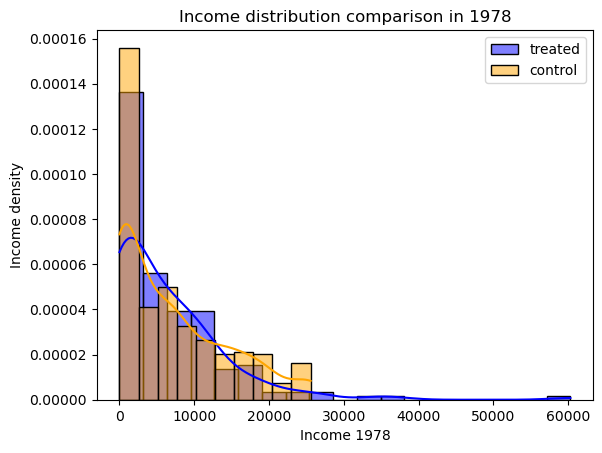

In [11]:
ax = sns.histplot(treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

Mean re78 for treated:  6349.143530270269
Mean re78 for untreated:  6984.169742307697


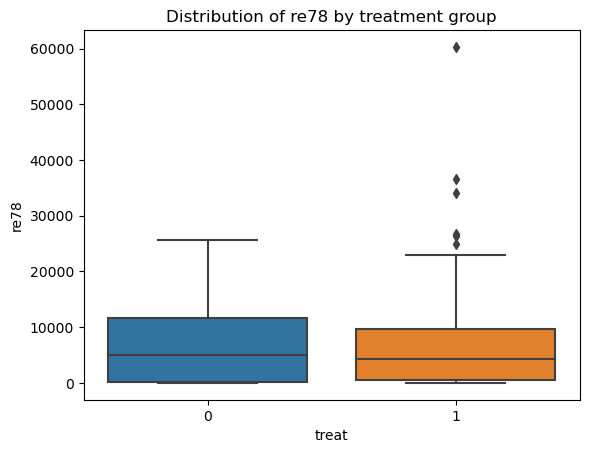

In [12]:

ax = sns.boxplot(x="treat", y="re78", data=lalonde)
ax.set_title('Distribution of re78 by treatment group')
print('Mean re78 for treated: ', lalonde[lalonde.treat == 1].re78.mean())
print('Mean re78 for untreated: ', lalonde[lalonde.treat == 0].re78.mean())


A naive observer could say, that the mean of treated group is lower, and therefore the the treatment does not work. 

However, les naive researcher can see, that the difference was very significant initially, and the change in the difference has changed positiviely.  However, with large uncertainty.

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

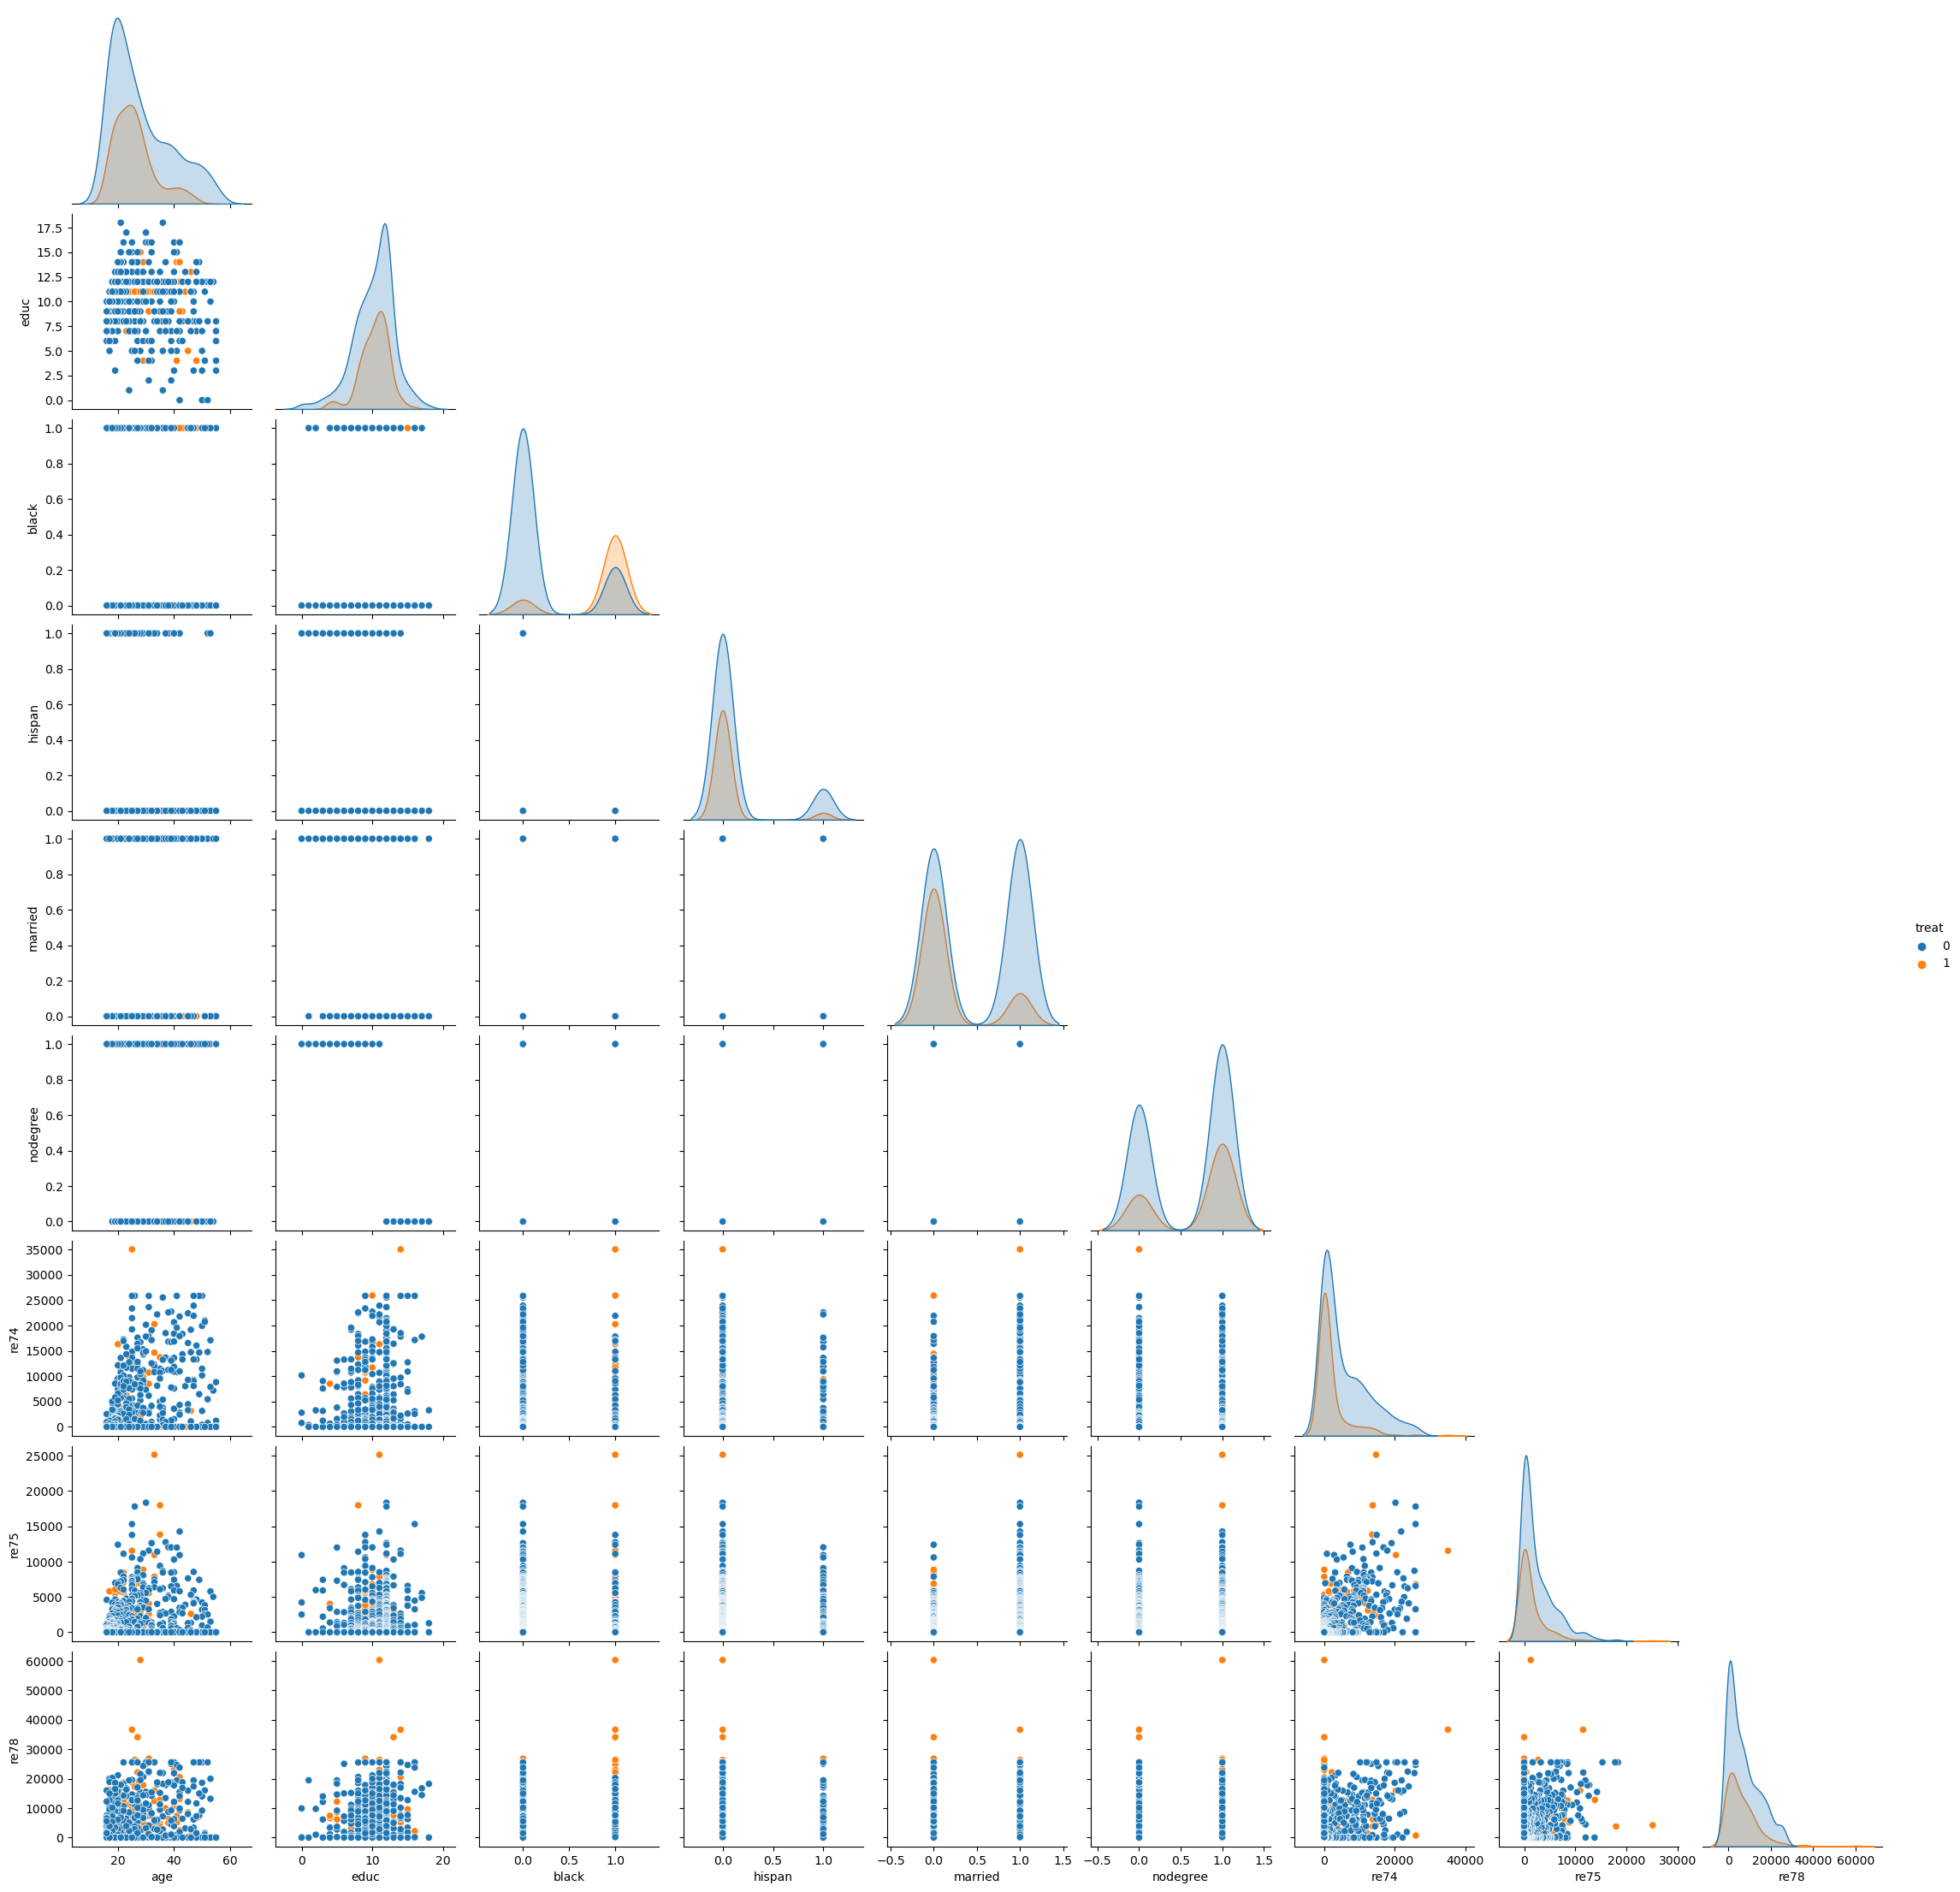

In [13]:
#pd.plotting.scatter_matrix(lalonde, figsize=(15, 15))
sns.pairplot(lalonde, hue='treat', diag_kind='kde', corner=True)

In [45]:
print((lalonde['black'] == 1).sum())
print((lalonde['hispan'] == 1).sum())
print((lalonde.query('hispan == 0 & black ==0').shape[0]))

243
72
299


<AxesSubplot:xlabel='race', ylabel='count'>

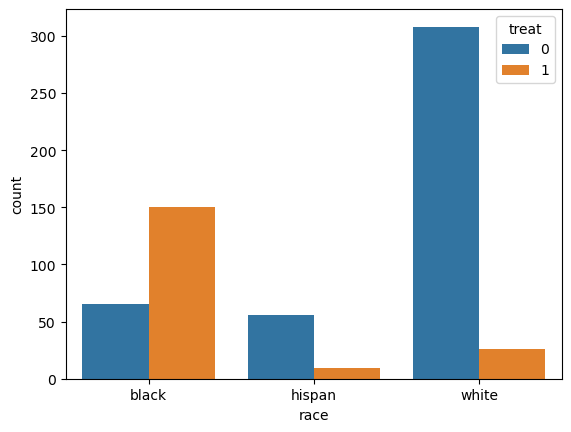

In [40]:
# create a white column in lalonde dataframe, which is 1 when black is 0 and hispanic is 0
lalonde['white'] = ((lalonde['black'] == 0) | (lalonde['hispan'] == 1)).astype(int)

x = lalonde[['white', 'black', 'hispan']].stack()
lalonde['race'] = pd.Series(pd.Categorical(x[x!=0].index.get_level_values(1)))

sns.countplot(data=lalonde, x="race", hue='treat')


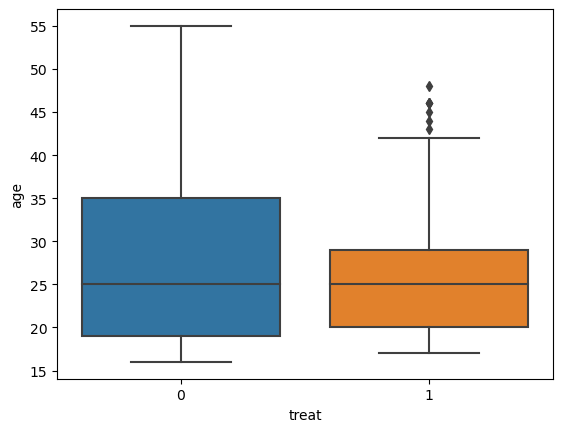

In [15]:
ax = sns.boxplot(x="treat", y="age", data=lalonde)

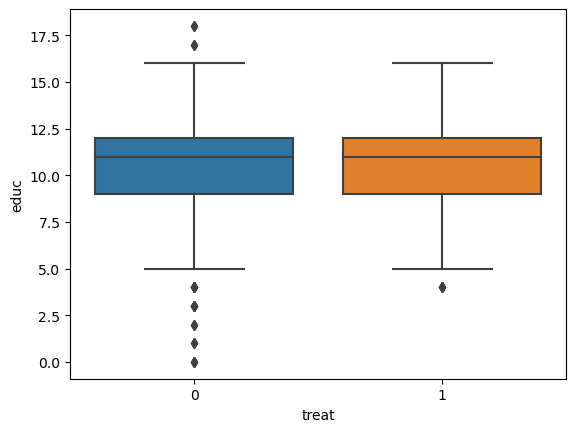

In [16]:
ax = sns.boxplot(x="treat", y="educ", data=lalonde)

<AxesSubplot:xlabel='married', ylabel='count'>

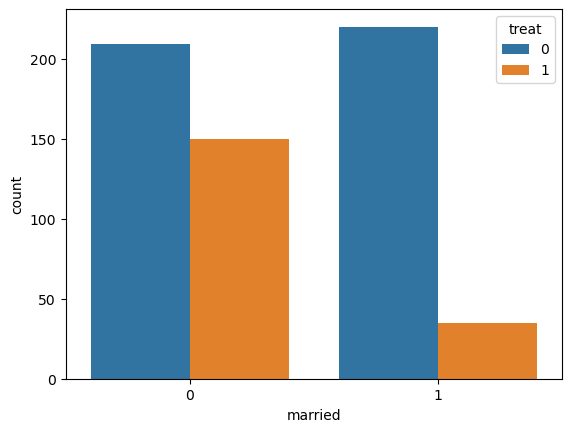

In [17]:
sns.countplot(data=lalonde, x="married", hue='treat')

<AxesSubplot:xlabel='nodegree', ylabel='count'>

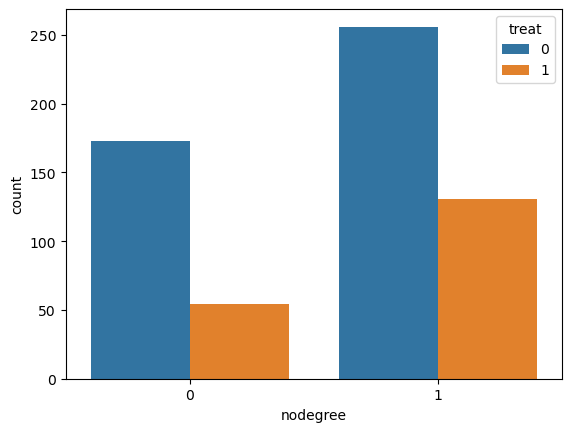

In [46]:
# mar_percs_counts = (df.groupby(['income'])['occupation']
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .mul(100)
#                      .reset_index()
#                      .sort_values('occupation'))

sns.countplot(data=lalonde, x="nodegree", hue='treat')

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [36]:

print(lalonde.query('black == 0 & hispan ==0').shape[0])

299


In [20]:
# standardize continuos column variables of dataframe lalonde
lalonde['age'] = (lalonde['age'] - lalonde.age.mean())/lalonde['age'].std()
lalonde['educ'] = (lalonde['educ'] - lalonde.educ.mean())/lalonde['educ'].std()
lalonde['re74'] = (lalonde['re74'] - lalonde.re74.mean())/lalonde['re74'].std()
lalonde['re75'] = (lalonde['re75'] - lalonde.re75.mean())/lalonde['re75'].std()


mod = smf.logit(formula='treat ~  age + educ + C(black) + C(hispan)  + C(married) + C(nodegree) + \
        +re74 + re75', data=lalonde)

res = mod.fit()

# Extract the estimated propensity scores
lalonde['prop_score'] = res.predict()

#print(res.predict())

print(res.summary())


Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                  0.3508
Time:                        11:03:45   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [51]:
import networkx as nx



# create arary of tuples from lalonde dataframe, where each tuple contains one id of person with treat = 1 and one id of person with treat = 0 and difference in propensity scores
w_edges = [(i, j, 1-abs(lalonde.loc[i, 'prop_score'] - lalonde.loc[j, 'prop_score']))  for i in lalonde[lalonde.treat == 1].index for j in lalonde[lalonde.treat == 0].index]

G = nx.Graph()
G.add_weighted_edges_from(w_edges)
matching = nx.max_weight_matching(G)

In [56]:
ids = list(sum(matching, ())) #flatten the matches
lalonde_matched = lalonde.loc[ids]
lalonde_matched.shape

(370, 14)

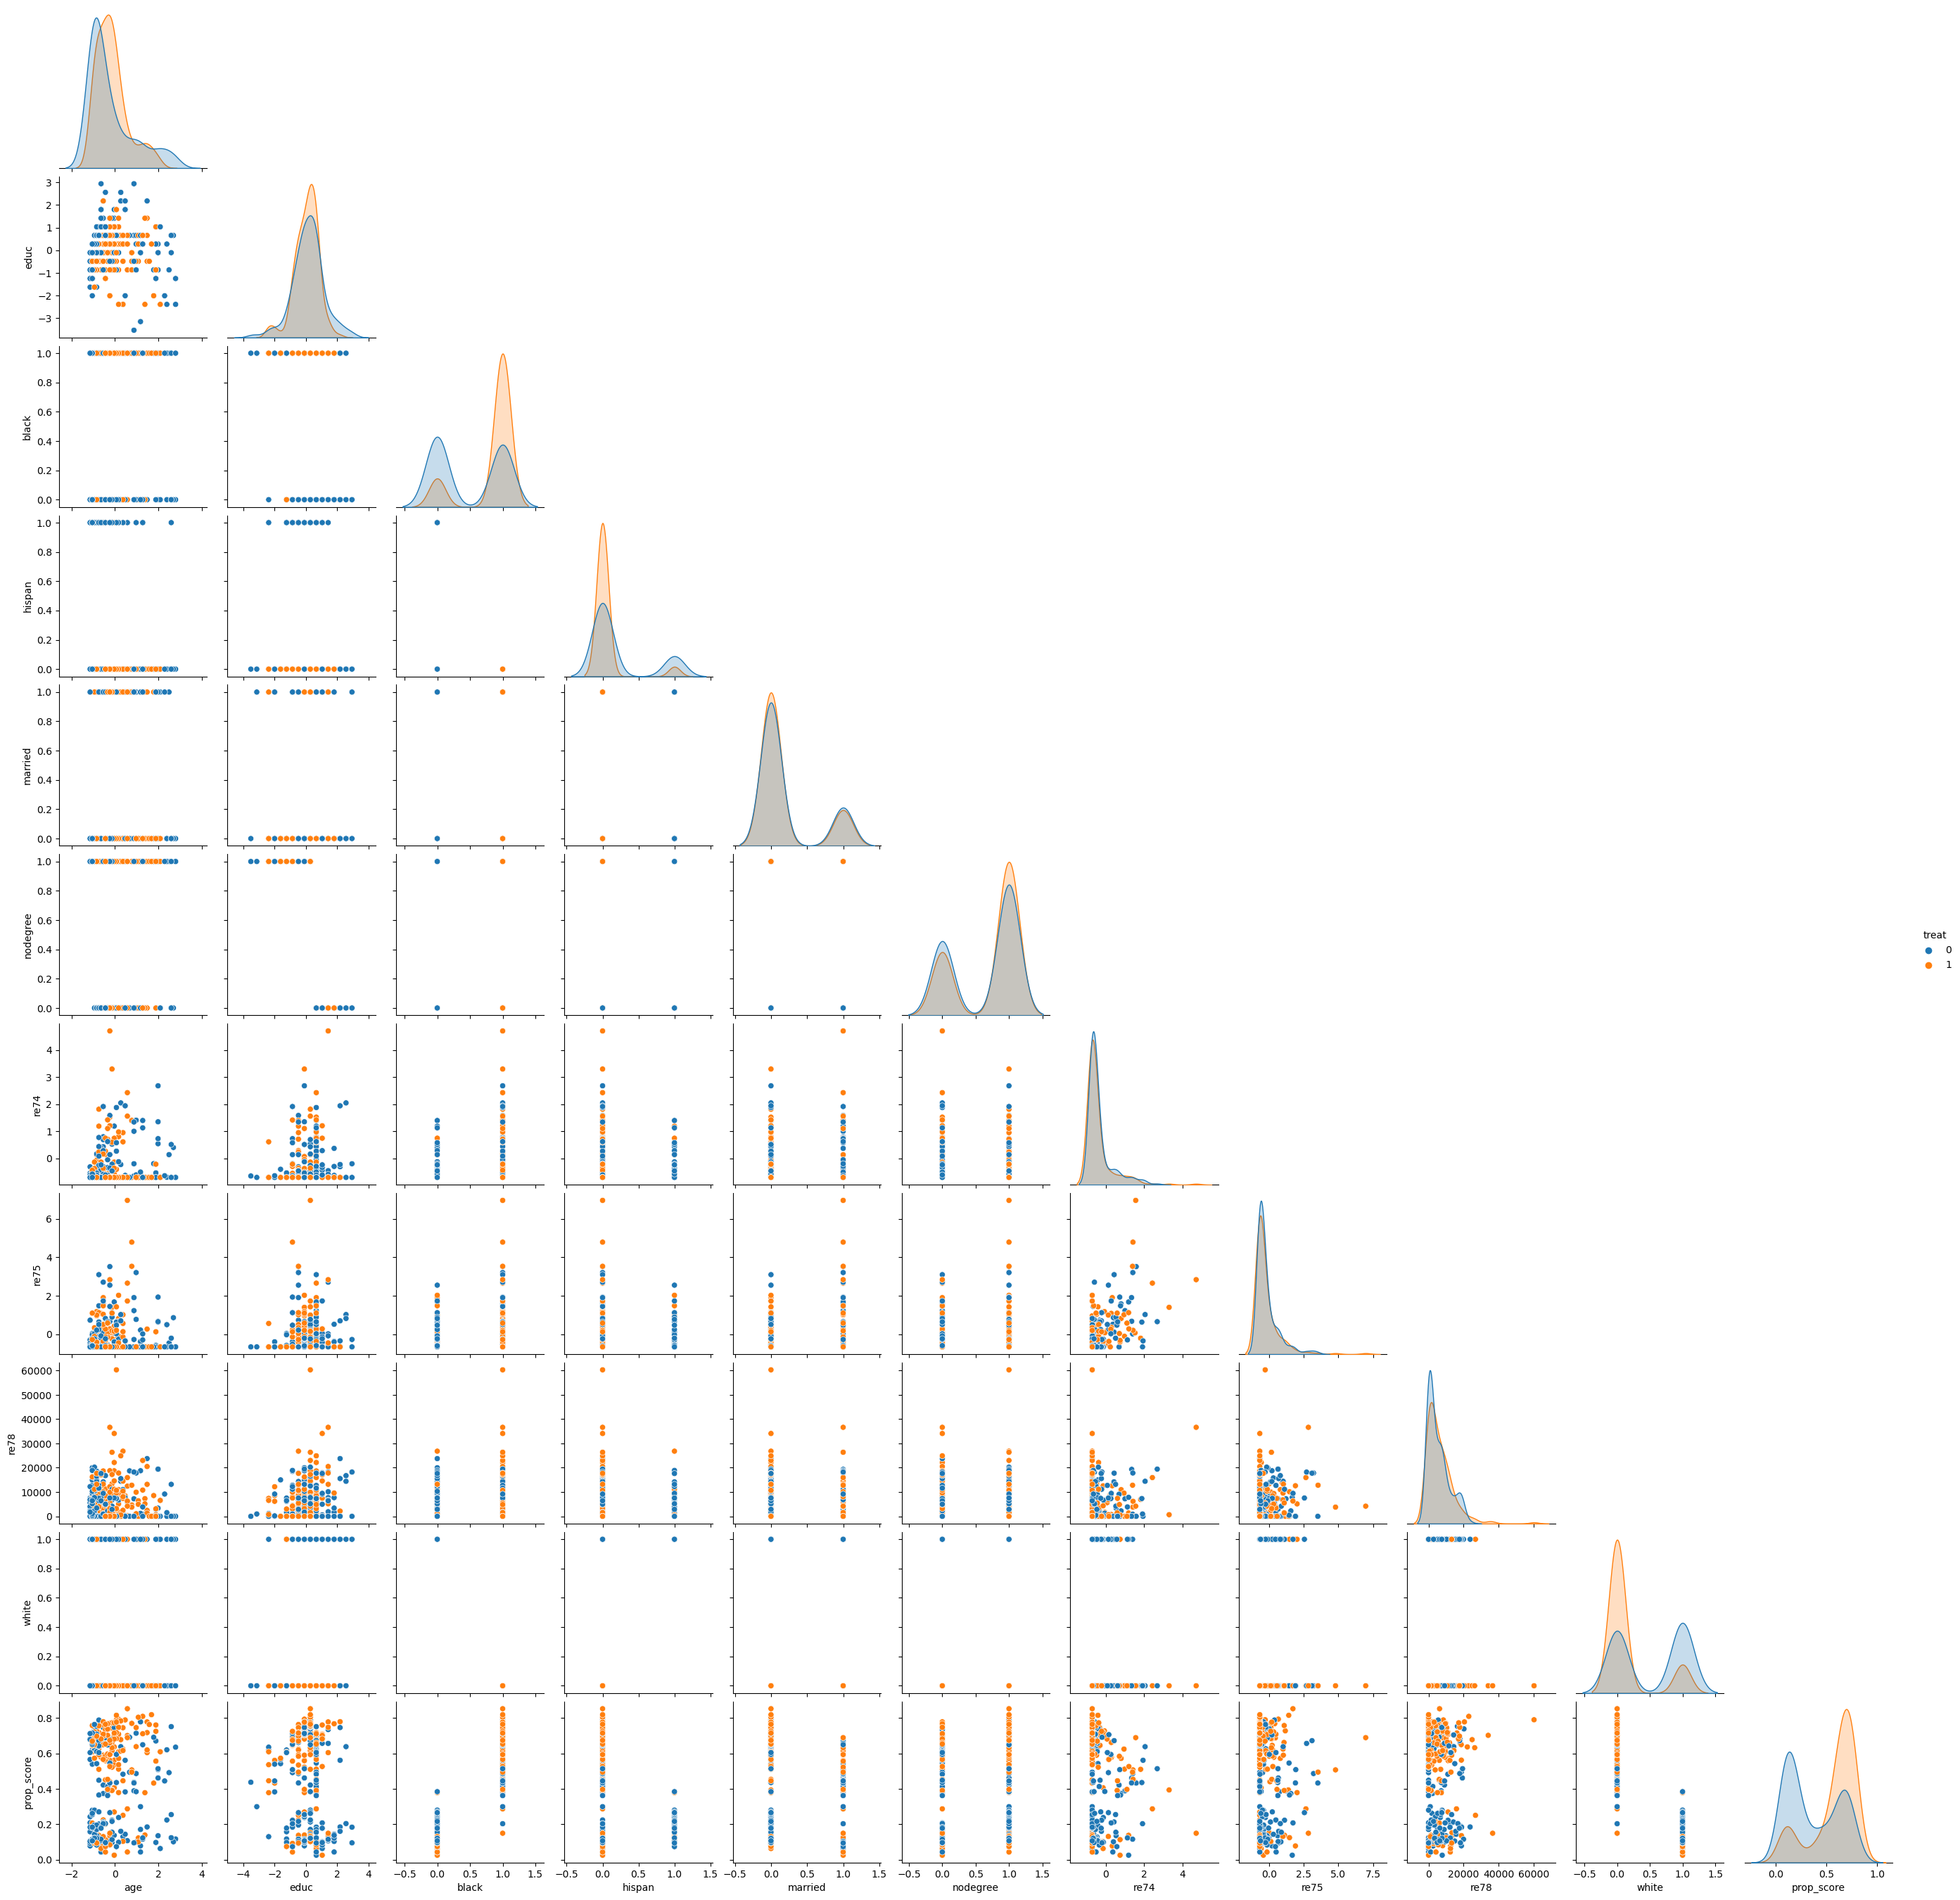

In [57]:

sns.pairplot(lalonde_matched, hue='treat', diag_kind='kde', corner=True)

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [48]:
# while going through the aformentioned plotmatrix, we can see that the race is not balanced in the control and treatment group. - what is more, there is a significant disbalance even in the propensity scores
# the race could be the coufounder in this experiment, so we need to balance it
# we will just drop the rows, where the values are not matched - we could also incorporate it in the edge weights, but this could negatively affect the propensity score matching


w_edges = [(i, j, 1-abs(lalonde.loc[i, 'prop_score'] - lalonde.loc[j, 'prop_score'])) \
            for i in lalonde[lalonde.treat == 1].index \
                for j in lalonde[lalonde.treat == 0].index \
                    if (lalonde.loc[i, 'black'] == lalonde.loc[j, 'black']) & (lalonde.loc[i, 'hispan'] == lalonde.loc[j, 'hispan'])]


G = nx.Graph()
G.add_weighted_edges_from(w_edges)
matching = nx.max_weight_matching(G) 
ids = list(sum(matching, ())) #flatten the matches


In [49]:
ids = list(sum(matching, ())) #flatten the matches
lalonde_matched2 = lalonde.loc[ids]
lalonde_matched2.shape

(232, 14)

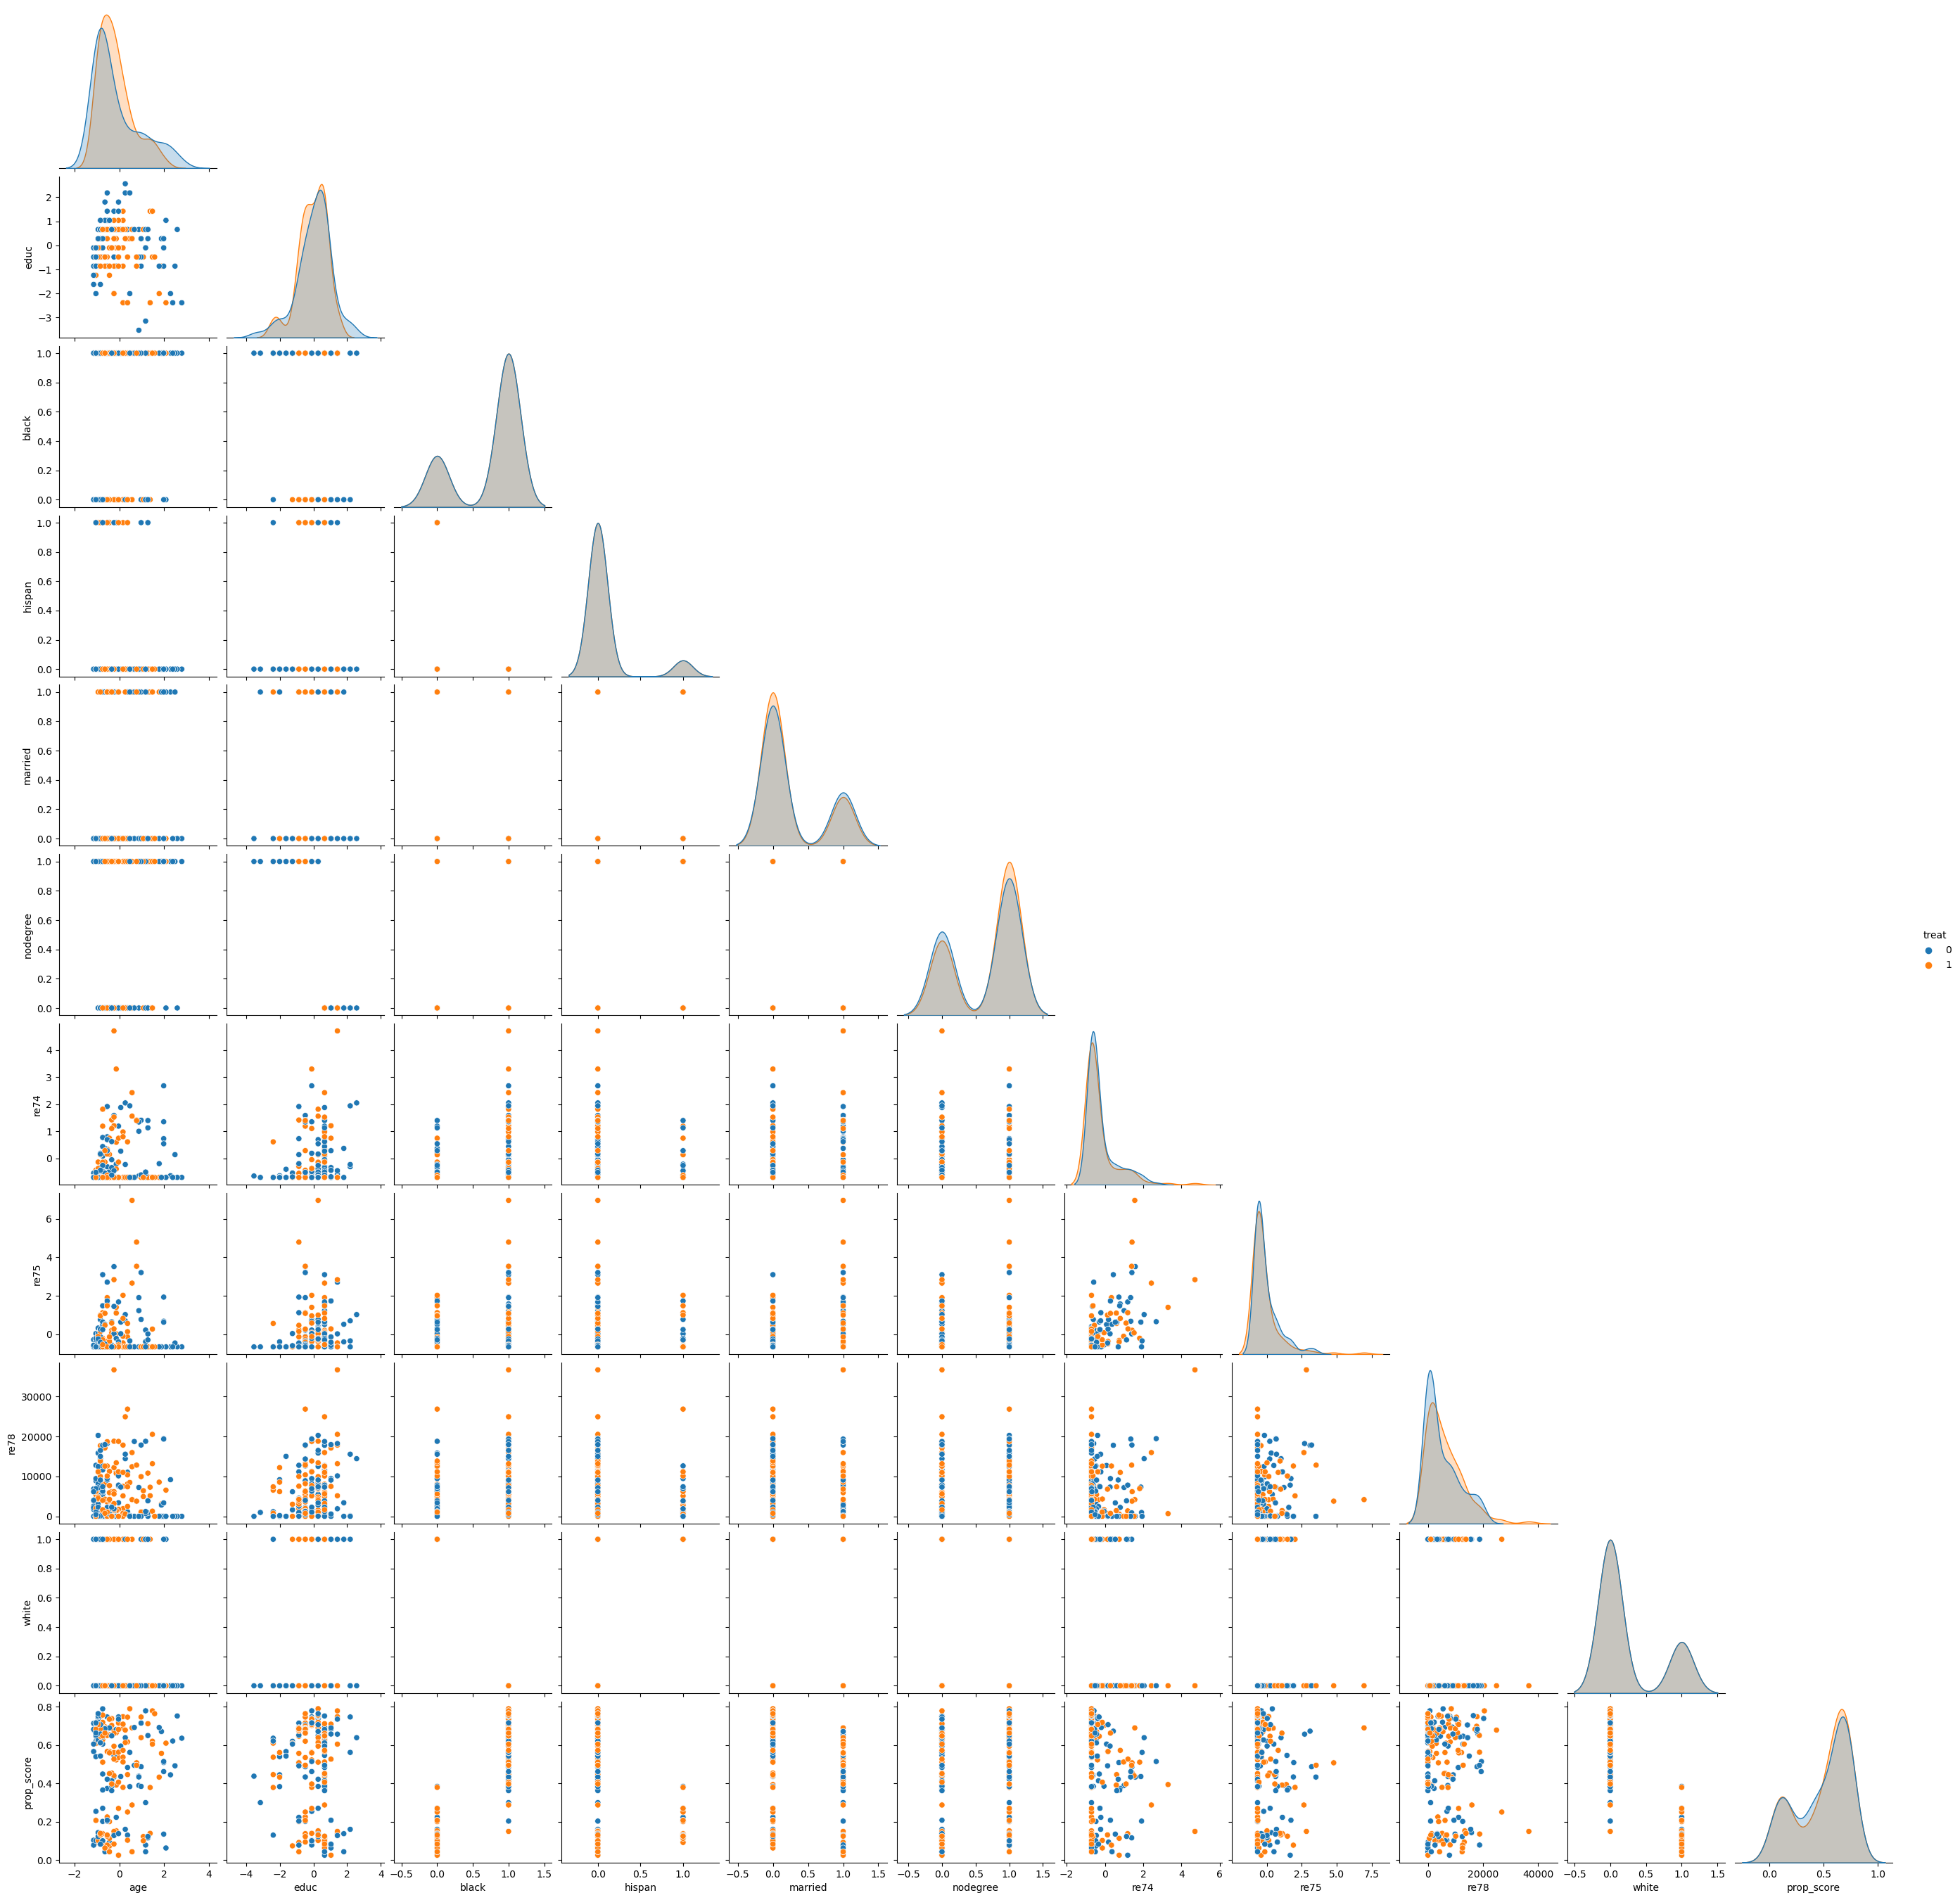

In [50]:

sns.pairplot(lalonde_matched2, hue='treat', diag_kind='kde', corner=True)

In [ ]:
# now we can see that the race is balanced in the control and treatment group and the propensity scores are also way better balanced, however, now we have only 232 samples

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [53]:
lalonde_matched2[lalonde_matched2.treat == 1].re78.describe()

count      116.000000
mean      6166.431753
std       6655.656670
min          0.000000
25%        672.490925
50%       4300.659000
75%      10001.218250
max      36646.950000
Name: re78, dtype: float64

In [54]:
lalonde_matched2[lalonde_matched2.treat == 0].re78.describe()

count      116.000000
mean      5095.456025
std       6047.014862
min          0.000000
25%          0.000000
50%       2256.488500
75%       8942.092750
max      20243.380000
Name: re78, dtype: float64

In [60]:
treated = lalonde_matched2[lalonde_matched2['treat'] == 1] #People that attained the programme
control = lalonde_matched2[lalonde_matched2['treat'] == 0] #People that didn't attain the programme

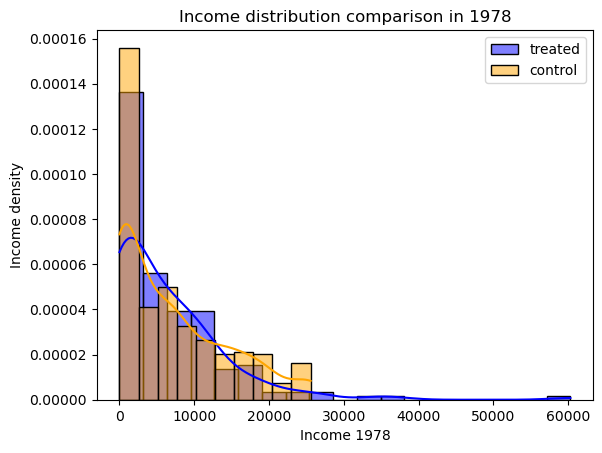

In [62]:
ax = sns.histplot(treated['re78'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(control['re78'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Income distribution comparison in 1978',xlabel='Income 1978', ylabel='Income density')
plt.legend()
plt.show()

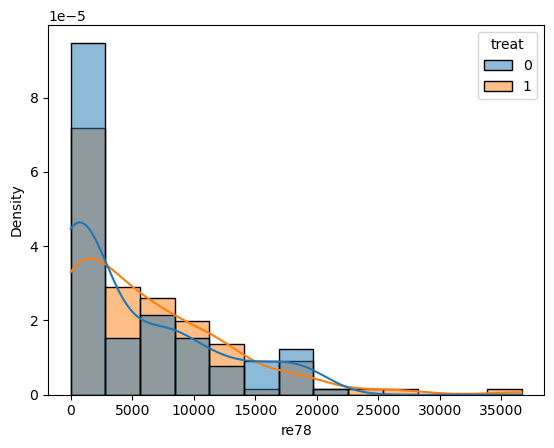

In [63]:
ax = sns.histplot(data=lalonde_matched2, x='re78', hue='treat', stat='density', kde=True, log_scale=(False))

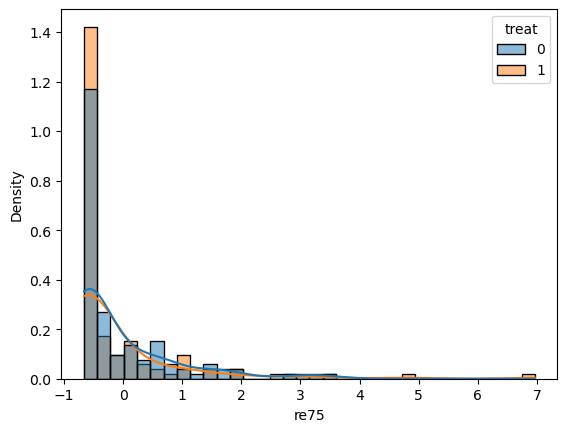

In [64]:
ax = sns.histplot(data=lalonde_matched2, x='re75', hue='treat', stat='density', kde=True, log_scale=(False))

Text(0.5, 1.0, 'Distribution of re78 by treatment group')

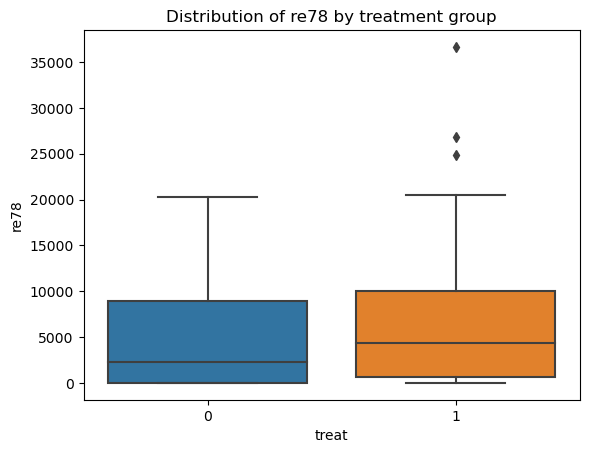

In [61]:

ax = sns.boxplot(x="treat", y="re78", data=lalonde_matched2)
ax.set_title('Distribution of re78 by treatment group')